In [ ]:
import torch
import torch.nn as nn
import numpy as np

np.random.seed(0)
torch.manual_seed(0)

def prepare(sequence):
    SEQ_LENGTH = sequence
    data = np.load("1.npy")
    testdata = np.load("1.npy")

    datapoints = len(data)

    data = data[:int(datapoints * 0.7)]
    testdata = testdata[int(datapoints * 0.7):]

    data = (data - np.mean(data)) / np.std(data)

    def create_sequences(data, testdata, seq_length):
        xs = []
        ys = []
        tests = []
        test_ys = []
        for i in range(len(data) - seq_length):
            x = data[i: (i + seq_length)] # 20 datapoints
            y = data[i + seq_length] # 21st datapoint
            test = testdata[i: (i + seq_length)]
            
            if i + seq_length < len(testdata):
                test = testdata[i: (i + seq_length)]
                test_y = testdata[i + seq_length]
                tests.append(test)
                test_ys.append(test_y)
            xs.append(x)
            ys.append(y)
        
        return np.array(xs), np.array(ys), np.array(tests), np.array(test_ys)

    X, y, TEST, TEST_y = create_sequences(data, testdata, SEQ_LENGTH)

    TRAIN_X = torch.tensor(X[:, :, None], dtype=torch.float32)
    TRAIN_Y = torch.tensor(y[:, None], dtype=torch.float32)

    TEST_X = torch.tensor(TEST[:, :, None], dtype=torch.float32)
    TEST_Y = torch.tensor(TEST_y[:, None], dtype=torch.float32)

    return TRAIN_X, TRAIN_Y, TEST_X, TEST_Y

In [168]:
TRAIN_X, TRAIN_Y, TEST_X, TEST_Y = prepare(15)

In [169]:
TEST_X.shape, TRAIN_X.shape

(torch.Size([15, 15, 1]), torch.Size([54, 15, 1]))

In [170]:
TEST_Y.shape, TRAIN_Y.shape

(torch.Size([15, 1]), torch.Size([54, 1]))

In [171]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, layer_dim, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.layer_dim = layer_dim
        self.lstm = nn.LSTM(input_dim, hidden_dim, layer_dim, batch_first = True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, h0 = None, c0 = None):
        if h0 is None or c0 is None:
            h0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
            c0 = torch.zeros(self.layer_dim, x.size(0), self.hidden_dim).to(x.device)
        
        out, (hn, cn) = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out, hn, cn

In [172]:
def define_model(hidden, learning):
    model = LSTMModel(input_dim = 1, hidden_dim = hidden, layer_dim = 1, output_dim = 1)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning)

    return model, criterion, optimizer

In [173]:
def train(model, criterion, optimizer, TRAIN_X, TRAIN_Y, epochs):
    num_epochs = epochs
    h0, c0 = None, None

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()

        outputs, h0, c0 = model(TRAIN_X, h0, c0)

        loss = criterion(outputs, TRAIN_Y)
        loss.backward()
        optimizer.step()

        h0 = h0.detach()
        c0 = c0.detach()

    return h0, c0

In [184]:
# def test(model, TRAIN_X, TRAIN_Y, h0, c0):
#     model.eval()
#     predicted, _, _ = model(TRAIN_X, h0, c0)

#     predicted = predicted.detach().numpy()

#     return np.sqrt(np.mean((predicted.flatten() - TRAIN_Y.flatten().numpy())**2))
def test(model, X, Y):
    model.eval()
    batch_size = X.size(0)
    device = X.device

    # Reinitialize hidden and cell state to match test batch size
    h0 = torch.zeros(model.layer_dim, batch_size, model.hidden_dim).to(device)
    c0 = torch.zeros(model.layer_dim, batch_size, model.hidden_dim).to(device)

    with torch.no_grad():
        predicted, _, _ = model(X, h0, c0)
        predicted = predicted.detach().cpu().numpy()
        Y_np = Y.detach().cpu().numpy()

    return np.sqrt(np.mean((predicted.flatten() - Y_np.flatten())**2))


def predict(model, X):
    model.eval()
    batch_size = X.size(0)
    device = X.device

    h0 = torch.zeros(model.layer_dim, batch_size, model.hidden_dim).to(device)
    c0 = torch.zeros(model.layer_dim, batch_size, model.hidden_dim).to(device)

    with torch.no_grad():
        predicted, _, _ = model(X, h0, c0)
        predicted = predicted.detach().cpu().numpy()
    
    return predicted
    

In [176]:
epochs = [100, 200, 300, 400, 500]
sequences = [5, 10, 15, 20]
hidden = [50, 100, 150, 200, 250]
learning = [0.1, 0.01, 0.001, 0.0001]

results = np.zeros((len(epochs), len(sequences), len(hidden), len(learning)))

for epoch_index in range(len(epochs)):
    for sequence_index in range(len(sequences)):
        for hidden_index in range(len(hidden)):
            for learning_index in range(len(learning)):
                TRAIN_X, TRAIN_Y, TEST_X, TEST_Y = prepare(sequences[sequence_index])
                model, criterion, optimizer = define_model(hidden[hidden_index], learning[learning_index])
                h0, c0 = train(model, criterion, optimizer, TRAIN_X, TRAIN_Y, epochs[epoch_index])

                rsme = test(model, TEST_X, TEST_Y)

                results[epoch_index][sequence_index][hidden_index][learning_index] = rsme

KeyboardInterrupt: 

In [68]:
import matplotlib.pyplot as plt

def visualize(model, TRAIN_X, h0, c0, data, seq_length):
    model.eval()
    predicted, _, _ = model(TRAIN_X, h0, c0)

    predicted = predicted.detach().numpy()

    original = data[seq_length:]
    time_steps = np.arange(seq_length, len(data))

    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, original, label='Original Data')
    plt.plot(time_steps, predicted, label='Predicted Data', linestyle='--')
    plt.title('LSTM Model Predictions vs. Original Data')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

visualize(model, TRAIN_X, h0, c0, dataset, 10)

NameError: name 'dataset' is not defined

In [69]:
rsme

0.8375309

In [120]:
results[0].shape

(4, 5, 4)

In [121]:
epochs = [100, 200, 300, 400, 500]
sequences = [5, 10, 15, 20]
hidden = [50, 100, 150, 200, 250]
learning = [0.1, 0.01, 0.001, 0.0001]

# 100 epochs
results[0]

# 0.739133 at 100 epochs with 15 sequence_length 100 hidden layers and learning rate of .01

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]])

In [122]:
epochs = [100, 200, 300, 400, 500]
sequences = [5, 10, 15, 20]
hidden = [50, 100, 150, 200, 250]
learning = [0.1, 0.01, 0.001, 0.0001]

# 200 epochs
results[1]

# 0.61818993 at 200 epochs with 10 sequence_length 50 hidden layers and learning rate of .01

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]])

In [123]:
epochs = [100, 200, 300, 400, 500]
sequences = [5, 10, 15, 20]
hidden = [50, 100, 150, 200, 250]
learning = [0.1, 0.01, 0.001, 0.0001]

# 300 epochs
results[2]

# 0.07704759 at 300 epochs with 15 sequence_length 100 hidden layers and learning rate of .1

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]])

In [124]:
epochs = [100, 200, 300, 400, 500]
sequences = [5, 10, 15, 20]
hidden = [50, 100, 150, 200, 250]
learning = [0.1, 0.01, 0.001, 0.0001]

# 400 epochs
results[3]

# 0.02648036 at 400 epochs with 15 sequence_length 200 hidden layers and learning rate of .01

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]])

In [125]:
epochs = [100, 200, 300, 400, 500]
sequences = [5, 10, 15, 20]
hidden = [50, 100, 150, 200, 250]
learning = [0.1, 0.01, 0.001, 0.0001]

# 500 epochs
results[4]

# 0.03323467 at 500 epochs with 15 sequence_length 250 hidden layers and learning rate of .01

array([[[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]],

       [[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]]])

In [178]:
# 0.02648036 at 400 epochs with 15 sequence_length 200 hidden layers and learning rate of .01

TRAIN_X, TRAIN_Y, TEST_X, TEST_Y = prepare(15)
model, criterion, optimizer = define_model(200, 0.01)
h0, c0 = train(model, criterion, optimizer, TRAIN_X, TRAIN_Y, 400)
h0_test = h0[:, :TEST_X.size(0), :].contiguous()
c0_test = c0[:, :TEST_X.size(0), :].contiguous()

rsme = test(model, TEST_X, TEST_Y)

In [179]:
rsme

32.66866

In [ ]:
TEST_X[-1].unsqueeze(0)

torch.Size([15, 1])

In [194]:
TEST_X.shape, TEST_Y.shape

predict(model, TEST_X[-1].unsqueeze(0))[0][0]

1.131635

ValueError: x and y must have same first dimension, but have shapes (270,) and (285, 1)

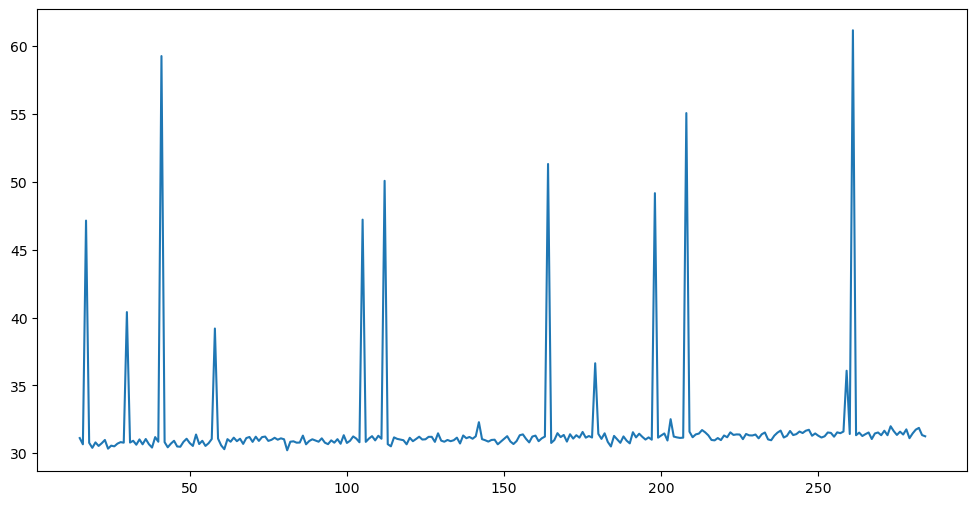

In [111]:
import matplotlib.pyplot as plt

def visualize(model, h0, c0, TEST_Y, seq_length, TEST_X):
    model.eval()
    predicted, _, _ = model(TEST_X, h0, c0)

    predicted = predicted.detach().numpy()

    original = TEST_Y[seq_length:]
    time_steps = np.arange(seq_length, len(TEST_Y))

    plt.figure(figsize=(12, 6))
    plt.plot(time_steps, original, label='Original Data')
    plt.plot(time_steps, predicted, label='Predicted Data', linestyle='--')
    plt.title('LSTM Model Predictions vs. Original Data')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

visualize(model, h0_test, c0_test, TEST_Y, 15, TEST_X)

In [ ]:
import influxdb_client
import pandas as pd
from influxdb_client.client.write_api import SYNCHRONOUS
from environs import env
import json


def lstm():
    TRAIN_X, TRAIN_Y, TEST_X, _ = prepare(15)
    model, criterion, optimizer = define_model(200, 0.01)
    train(model, criterion, optimizer, TRAIN_X, TRAIN_Y, 400)

    return model, TEST_X

def env_setup():
    env.read_env()
    bucket = env("INFLUXDB_BUCKET")
    org = env("INFLUXDB_ORGANIZATION")
    token = env("INFLUXDB_TOKEN")

    return token, org, bucket

def parse_data():
    df = pd.read_csv("../data/100_thermal_data.csv")
    result = df.head()
    print(result)
    return df

def main():
    model, TEST_X = lstm()

    df = parse_data()
    index = 71
    test_index = 0

    token, org, bucket = env_setup()
    url="http://localhost:8086"

    client = influxdb_client.InfluxDBClient(
        url=url,
        token=token,
        org=org
    )

    write_api = client.write_api(write_options=SYNCHRONOUS)

    while test_index < 30:
        timestamp = df.iloc[index]

        prediction = predict(model, TEST_X[test_index].unsqueeze(0))[0][0]

        try:            
            point = (
                influxdb_client.Point("thermal_readings")
                .tag("sensor", "SENSOR1")
                .field("temperature", prediction)
                .time(timestamp)
            )
            write_api.write(bucket=bucket, org=org, record=point)

            index += 1
            test_index += 1

        except Exception as e:
            print("❌ ERROR:", e)

In [191]:
TEST_X.shape

torch.Size([15, 15, 1])